<font size="10"> __Data analysis on Climate Change - Italy__ </font>

_Is climate change real? Is global warming really happening?_

<font size="5"> **Goal** </font>

_The goal of this project is to have a look at the evolution of the temperature in Italy. By using Python, this project aims to provide valuable insights that can help determine whether global warming and climate change are taking place in Italy or if it is just a conjecture. 
The analysis is performed on meterological data, retrieved from Copernicus ERA5, from 1970 to 2022. Temperature at 2 meters height was retrieved for these years. All the data is downloaded as NETCDF files and covers an area that goes from 6.61ºW to 18.36ºW longitude and from 36.64ºN to 46.89ºN latitude.
Besides temperature data, I also used a shapefile of Italy to focus the analysis only on those points that belong to the country._
<br><br> _To see how to download data from Copernicus ERA5 via API see:_ https://cds.climate.copernicus.eu/api-how-to


<font size="5"> **Setup** </font>

Importing the necessary libraries we will use for this project

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import xarray as xr
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
from shapely.geometry import Point
import cartopy.crs as crs
from  scipy.interpolate import interp2d
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
import cartopy.feature as cf
from sklearn import linear_model


<font size="5"> **Data preparation** </font>

To begin, let's have a look at the NetCDF file that contains all the records for the temperature at 2 meters for the area at stake. To do that, let's make a heatmap of the yearly average temperature of the area for one of the years of the dataset.
As can be seen, the NetCDF file has:
1) 3 coordinates: time, latitude and temperature.
2) 1 data variable: t2m - which represents the temperature at 2 meters height. The data is stored in a 3D matrix, where the first index represents the time, the second index represents the latitude and the third one represents the longitude. Temperature values are in Kelvin.

<xarray.Dataset>
Dimensions:    (longitude: 48, latitude: 42, time: 8760)
Coordinates:
  * longitude  (longitude) float32 6.61 6.86 7.11 7.36 ... 17.86 18.11 18.36
  * latitude   (latitude) float32 46.89 46.64 46.39 46.14 ... 37.14 36.89 36.64
  * time       (time) datetime64[ns] 1970-01-01 ... 1970-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-04 15:50:31 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...


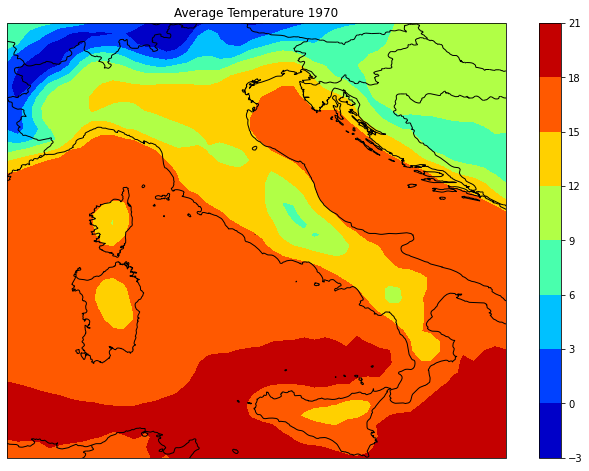

In [5]:
""" Open one file of the datasets to retrieve its information """

path=os.getcwd()   #### This is the path where the script and the data folder are located
file=xr.open_dataset(path+'\Data\IT_temp1970.nc')
print(file)

fig=plt.figure(figsize=(12,8))
ax=plt.axes(projection=crs.PlateCarree())

graph=ax.contourf(file.longitude.values, file.latitude.values, np.nanmean(file.t2m.values, axis=0)-273.15, cmap=plt.cm.jet)
ax.set_title('Average Temperature 1970')
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS)
fig.colorbar(graph)

As we can see from the heatmap, the dataset contains the temperature values not only for Italy, but also for the surrounding countries and the sea. For the analysis, we should only consider the measurements relative to Italy mainland. To do that, we save in a list all the coordinates that fall within Italy's shapefile.

At the end, we check if the procedure worked correctly by plotting the points found and Italy's shapefile.

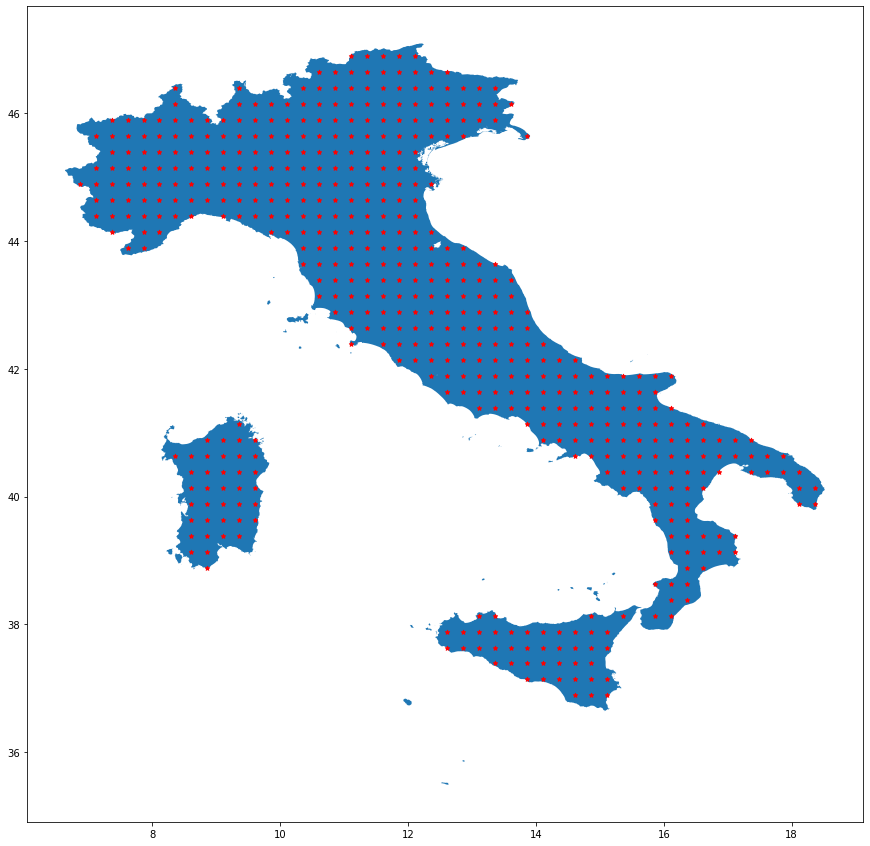

In [31]:
""" Save points of the dataset that fall within Italy's shapefile """

shapefile_ita=gpd.read_file(path+'\\Italy_shapefile\\bg854qz0981.shp')

points_val=[] 
points_ind=[] 

for lat in file.latitude.values:
    for lon in file.longitude.values:
        if (shapefile_ita.geometry.values.contains(Point(lon,lat))):
            points_val.append(tuple((lon,lat)))
            points_ind.append(tuple((np.where(file.longitude.values==lon)[0][0], np.where(file.latitude.values==lat)[0][0])))

fig,ax=plt.subplots(figsize=(15,15))
shapefile_ita.plot(ax=ax)

geom_point=[Point(p) for p in points_val]

geo_df=gpd.GeoDataFrame(geometry=geom_point)

g=geo_df.plot(ax=ax, markersize=20, color='red', marker='*')
plt.show()


Now, we create a function "temp_ita" that creates a matrix (with the same shape as file.t2m.values) with NaNs in points that do not belong to Italy mainland, whilst keeping the temperature values for the points that belong to Italy mainland.

In [11]:
def temp_ita(matrix,points_ind):
    temp_ita=np.empty(matrix.shape)
    temp_ita[:]=np.nan
    if matrix.ndim==3:
        for ind in points_ind:
            temp_ita[:,ind[1],ind[0]]=matrix[:,ind[1],ind[0]]
    else:
        for ind in points_ind:
            temp_ita[ind[1],ind[0]]=matrix[ind[1],ind[0]]
    temp_ita-=273.15
    return(temp_ita)

<font size="5"> **Data Analysis at country level** </font>

Now, we can start the Data Analysis step. We begin by plotting the trend of the yearly average temperature in Italy from 1970 to 2022. 
Furthermore, we compute a linear regression on the average values, to better estimate the real trend.

As can be seen, there is a clear trend in the average temperature, which overall increases throughout the years. From the linear regression it is possible to estimate an average increse of 0.04ºC per year.

100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:35<00:00,  1.47it/s]


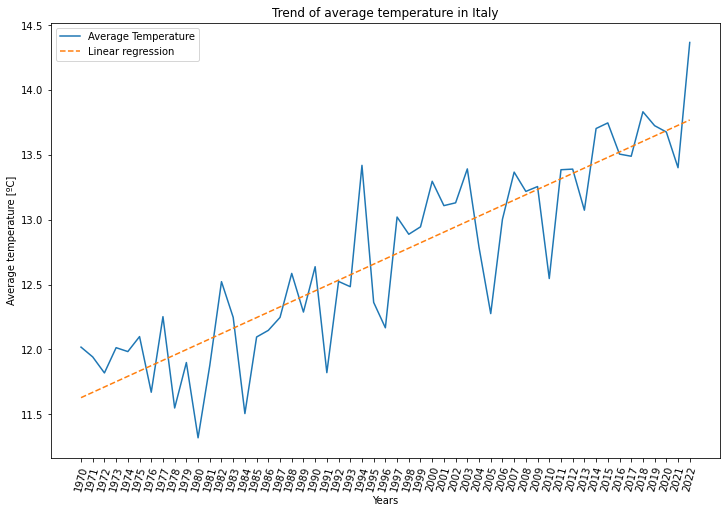

In [17]:
""" We open all the files of the datasets, we convert the temperature matrix using "temp_ita" to save only the temperature
values for Italy mainland, and we compute the yearly average temperature for the whole country """

avg_temp=[]

years=[str(y) for y in range (1970,2023)]

for y in tqdm(years):
    file=xr.open_dataset(path+'\Data\IT_temp'+y+'.nc')
    mat_temp_ita=temp_ita(file.t2m.values,points_ind)
    avg_temp.append(np.nanmean(mat_temp_ita))

reg = linear_model.LinearRegression()
X=(np.arange(1970,2023))
reg.fit(X.reshape(len(X), 1), avg_temp)
pred=reg.predict(X.reshape(len(X), 1))

fig,ax=plt.subplots(figsize=(12,8))

plt.xlabel('Years')
plt.ylabel('Average temperature [ºC]')
plt.title('Trend of average temperature in Italy')

plt.setp(ax.get_xticklabels(), rotation=75)
plt.plot(years,avg_temp, label='Average Temperature')
plt.plot(years, pred, linestyle='dashed', label='Linear regression')
plt.legend()
    

Now let's have a look at the distribution of the temperature in Italy for the whole timespan. To do that we make a boxplot, that besides showing the average temperature for each year also displays the max and min temperature as well as the 1st and 3rd quartile of the temperature distribution.

100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:31<00:00,  1.68it/s]


[Text(0.5, 0, 'Years'),
 Text(0, 0.5, 'Temperature [ºC]'),
 Text(0.5, 1.0, 'Trend of average temperature in Italy')]

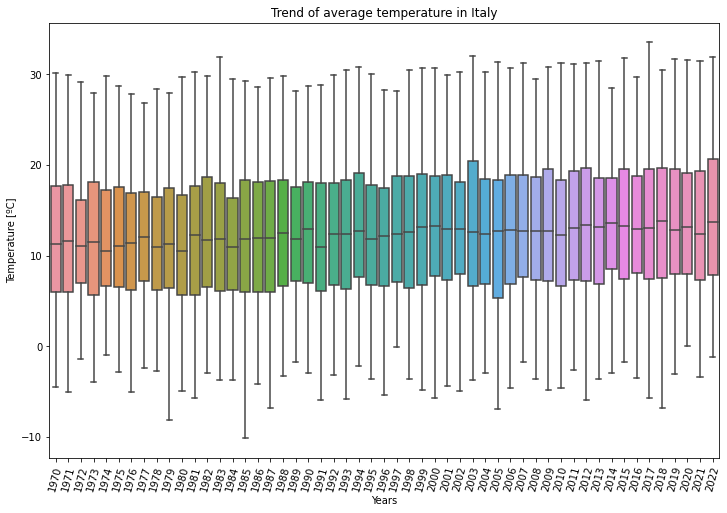

In [21]:
""" We open all the files of the datasets, we convert the temperature matrix using "temp_ita" to save only the temperature
values for Italy, and we compute the hourly average temperatures for the whole country """

temp=[]

years=[str(y) for y in range (1970,2023)]
years_vect=[y for y in range (1970,2023)]

for y in tqdm(years):
    file=xr.open_dataset(path+'\Data\IT_temp'+y+'.nc')
    mat_temp_ita=temp_ita(file.t2m.values,points_ind)
    avg_temp_it=np.nanmean(mat_temp_ita,(1,2))
    temp.append(avg_temp_it)

fig,ax=plt.subplots(figsize=(12,8))

sns.boxplot(data=temp,ax=ax)
ax.set_xticklabels(years, rotation=75)
ax.set(xlabel='Years', ylabel='Temperature [ºC]',title='Trend of average temperature in Italy') 

<font size="5"> **Data Analysis per Location** </font>

Now, we want to do the same analysis per location: North, Centre, South. In order to do that, we need to "split" the temperature matrix in 3 and thus we need to find what coordinates of the dataset fall within the different locations. We thus save these coordinates in three different lists, one for each location.
To do that, we use the shapefiles of the different regions.

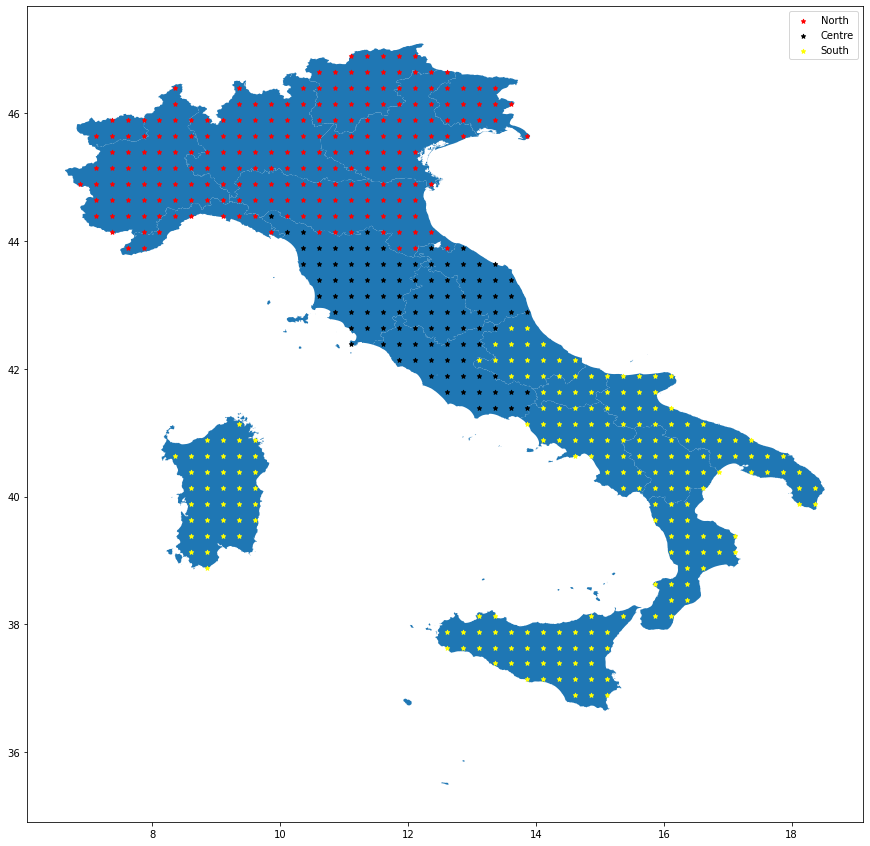

In [26]:
""" We want to perform the analysis for Northern, Central and Southern Italy. To do that, we need to see which points
of the datest fall in each one of the location. We use the shapefile of the Italian regions to identify these points. """

shapefile_regions=gpd.read_file(path+'\\Italy regions_shapefile\\ITA_adm1.shp')

shapefile_regions['Location']=['']*shapefile_regions.shape[0]

north=["Liguria","Piemonte","Valle d'Aosta","Lombardia","Emilia-Romagna","Trentino-Alto Adige","Veneto","Friuli-Venezia Giulia"]
centre=["Lazio","Marche","Toscana","Umbria"]
south=["Abruzzo","Basilicata","Calabria","Campania","Molise","Apulia","Sardegna","Sicily"]

for index in shapefile_regions.index:
    if(shapefile_regions['NAME_1'][index] in north):
        shapefile_regions.loc[index,'Location']='North'
    elif(shapefile_regions['NAME_1'][index] in centre):
        shapefile_regions.loc[index,'Location']='Centre'
    elif(shapefile_regions['NAME_1'][index] in south):
        shapefile_regions.loc[index,'Location']='South'

points_coords_north=[]
points_ind_north=[]

shapefile_regions_north=shapefile_regions[shapefile_regions['Location']=='North']
shapefile_north_indexes=np.array(shapefile_regions_north.index)


for lon in file.longitude.values:
    for lat in file.latitude.values:
        found=False
        ind=0
        while(not found and ind<len(shapefile_north_indexes)):
            if(shapefile_regions_north.geometry[shapefile_north_indexes[ind]].contains(Point(lon,lat))):
                found=True
                points_coords_north.append(Point(lon,lat))
                points_ind_north.append((np.where(file.longitude.values==lon)[0][0],np.where(file.latitude.values==lat)[0][0]))
            else:
                ind+=1

points_coords_centre=[]
points_ind_centre=[]

shapefile_regions_centre=shapefile_regions[shapefile_regions['Location']=='Centre']
shapefile_centre_indexes=np.array(shapefile_regions_centre.index)

for lon in file.longitude.values:
    for lat in file.latitude.values:
        found=False
        ind=0
        while(not found and ind<len(shapefile_centre_indexes)):
            if(shapefile_regions_centre.geometry[shapefile_centre_indexes[ind]].contains(Point(lon,lat))):
                found=True
                points_coords_centre.append(Point(lon,lat))
                points_ind_centre.append((np.where(file.longitude.values==lon)[0][0],np.where(file.latitude.values==lat)[0][0]))
            else:
                ind+=1

points_coords_south=[]
points_ind_south=[]

shapefile_regions_south=shapefile_regions[shapefile_regions['Location']=='South']
shapefile_south_indexes=np.array(shapefile_regions_south.index)

for lon in file.longitude.values:
    for lat in file.latitude.values:
        found=False
        ind=0
        while(not found and ind<len(shapefile_south_indexes)):
            if(shapefile_regions_south.geometry[shapefile_south_indexes[ind]].contains(Point(lon,lat))):
                found=True
                points_coords_south.append(Point(lon,lat))
                points_ind_south.append((np.where(file.longitude.values==lon)[0][0],np.where(file.latitude.values==lat)[0][0]))
            else:
                ind+=1

vect_geom=[points_coords_north, points_coords_centre, points_coords_south]


fig,ax=plt.subplots(figsize=(15,15))
shapefile_regions.plot(ax=ax)

color= ['red','black','yellow']
labels=['North', 'Centre', 'South']

for ind_geo in range(0,len(vect_geom)):
    geo=vect_geom[ind_geo]    
    geo_df=gpd.GeoDataFrame(geometry=geo)
    g=geo_df.plot(ax=ax, markersize=20, color=color[ind_geo], marker='*',label=labels[ind_geo])

ax.legend()                
               

Now, we can start the Data Analysis per location. We begin by plotting the trend of the yearly average temperature in Italy from 1970 to 2022 for the different locations.
Furthermore, we compute a linear regression on the average values, to estimate the real trend.

As we can see there is a clear trend in the average temperature, which overall increases throughout the years. From the linear regression we can estimate an average increse of 0.048ºC per year in the North, an increase of 0.038ºC in the Centre and 0.035ºC in the South.

100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [01:30<00:00,  1.71s/it]


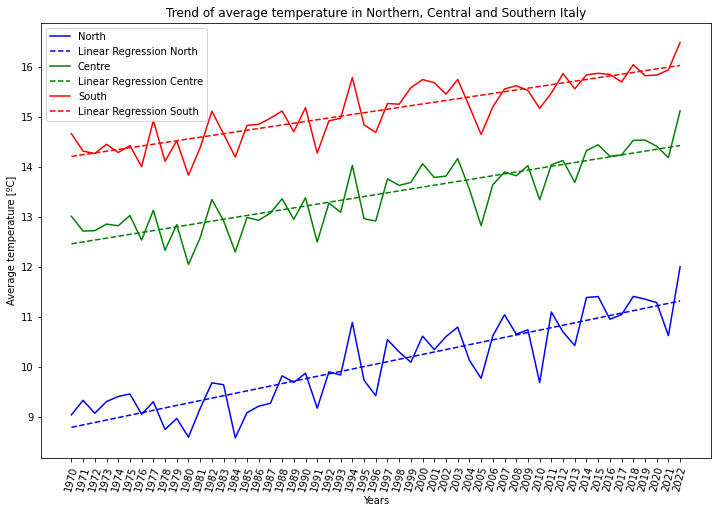

In [27]:
""" We open all the files of the datasets, we convert the temperature matrix using "temp_ita" to save only the temperature
values for Italy for each location, and we compute the yearly average temperature for each location """

avg_temp_north=[]
avg_temp_centre=[]
avg_temp_south=[]

years=[str(y) for y in range (1970,2023)]

for y in tqdm(years):
    file=xr.open_dataset(path+'\\Data\\IT_temp'+y+'.nc')
    mat_temp_north=temp_ita(file.t2m.values, points_ind_north)
    mat_temp_centre=temp_ita(file.t2m.values, points_ind_centre)
    mat_temp_south=temp_ita(file.t2m.values, points_ind_south)
    avg_temp_north.append(np.nanmean(mat_temp_north))
    avg_temp_centre.append(np.nanmean(mat_temp_centre))
    avg_temp_south.append(np.nanmean(mat_temp_south))
    
    
reg_North = linear_model.LinearRegression()
X=(np.arange(1970,2023))
reg_North.fit(X.reshape(len(X), 1), avg_temp_north)
pred_North=reg_North.predict(X.reshape(len(X), 1))

reg_Centre = linear_model.LinearRegression()
X=(np.arange(1970,2023))
reg_Centre.fit(X.reshape(len(X), 1), avg_temp_centre)
pred_Centre=reg_Centre.predict(X.reshape(len(X), 1))

reg_South = linear_model.LinearRegression()
X=(np.arange(1970,2023))
reg_South.fit(X.reshape(len(X), 1), avg_temp_south)
pred_South=reg_South.predict(X.reshape(len(X), 1))

fig,ax=plt.subplots(figsize=(12,8))

plt.xlabel('Years')
plt.ylabel('Average temperature [ºC]')
plt.title('Trend of average temperature in Northern, Central and Southern Italy')

plt.setp(ax.get_xticklabels(), rotation=75)
plt.plot(years, avg_temp_north, c='b', label='North')
plt.plot(years,pred_North,c='b',label='Linear Regression North', linestyle='dashed')
plt.plot(years, avg_temp_centre, c= 'g', label='Centre')
plt.plot(years,pred_Centre,c='g',label='Linear Regression Centre', linestyle='dashed')
plt.plot(years, avg_temp_south, c= 'r', label='South')
plt.plot(years,pred_South,c='r',label='Linear Regression South', linestyle='dashed')
plt.legend(loc="upper left")

Similarly, we can now make a boxplot for the different locations, to see how the temperature distribution is changing over time. This time we make it differently, by creating a dataframe where we have 3 columns: Years, Temperature and Location, and we use seaborn to plot it.

100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [04:09<00:00,  4.71s/it]


[Text(0.5, 0, 'Years'),
 Text(0, 0.5, 'Temperature [ºC]'),
 Text(0.5, 1.0, 'Trend of average temperature in Northern, Central and Southern Italy')]

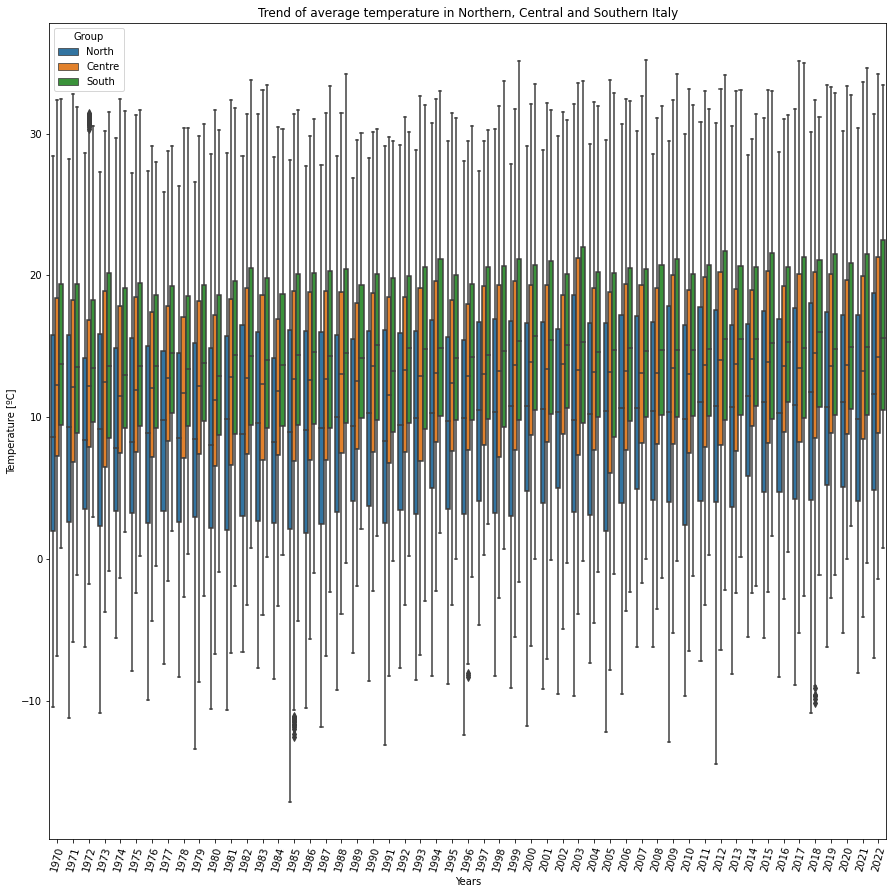

In [30]:
""" We open all the files of the datasets, we convert the temperature matrix using "temp_ita" to save only the temperature
values for Italy for each location, and we compute the hourly average temperature for each location """

years=[str(y) for y in range (1970,2023)]
years_vect=[y for y in range (1970,2023)]

dic_temp={'Years':[], 'Temperature':[], 'Location':[]}

for y in tqdm(years):
    file=xr.open_dataset(path+'\\Data\\IT_temp'+y+'.nc')
    mat_temp_north=temp_ita(file.t2m.values,points_ind_north)
    mat_temp_centre=temp_ita(file.t2m.values, points_ind_centre)
    mat_temp_south=temp_ita(file.t2m.values, points_ind_south)
    
    dic_temp['Years']+=[y]*file.time.size
    dic_temp['Temperature']+=list(np.nanmean(mat_temp_north,(1,2)))
    dic_temp['Location']+=['North']*file.time.size
    
    dic_temp['Years']+=[y]*file.time.size
    dic_temp['Temperature']+=list(np.nanmean(mat_temp_centre,(1,2)))
    dic_temp['Location']+=['Centre']*file.time.size
    
    dic_temp['Years']+=[y]*file.time.size
    dic_temp['Temperature']+=list(np.nanmean(mat_temp_south,(1,2)))
    dic_temp['Location']+=['South']*file.time.size
    
df_italy=pd.DataFrame(dic_temp)

fig,ax=plt.subplots(figsize=(15,15))
sns.boxplot(data=df_italy, x='Years', y='Temperature', hue='Location',ax=ax)
ax.set_xticklabels(years, rotation=75)
ax.set(xlabel='Years', ylabel='Temperature [ºC]',title='Trend of average temperature in Northern, Central and Southern Italy')            

<font size="5"> **Data Analysis - Animated heatmap** </font>

Finally, let's make an animated heatmap, that shows the variation of the temperature in the Italian Peninsula from 1970 to 2022. In order to increase the resolution of the heatmap, we generate temperature matrixes with higher granularity for each year and then we plot the yearly temperature for Italy.

In [70]:
""" Now we increase the granularity of the data. Initially we had a grid of 0.25ºx0.25º, which we improve by creating a grid of
0.1ºxo.1º. Like this we have more temperature points that increase the resolution of the heatmap. """

file=xr.open_dataset(path+'\\Data\\IT_temp1970.nc')

lon_hres=np.arange(file.longitude.values[0], file.longitude.values[-1], 0.1)
lat_hres=np.arange(file.latitude.values[-1], file.latitude.values[0], 0.1)

points_val_interp=[] 
points_ind_interp=[] 

for lat in tqdm (lat_hres):
    for lon in lon_hres:
        if (shapefile_ita.geometry.values.contains(Point(lon,lat))):
            points_val_interp.append(tuple((lon,lat)))
            points_ind_interp.append(tuple((np.where(lon_hres==lon)[0][0], np.where(lat_hres==lat)[0][0])))



100%|██████████████████████████████████████████████████████████████████████████████| 103/103 [1:42:52<00:00, 59.93s/it]


In [71]:
years=[str(y) for y in range (1970,2023)]

temp=[]

for y in tqdm(years):
    file=xr.open_dataset(path+'\\Data\\IT_temp'+y+'.nc')
    f_int_temp=interp2d(file.longitude.values, file.latitude.values, np.mean(file.t2m.values, axis=0))
    mat_temp=f_int_temp(lon_hres,lat_hres)
    mat_temp_ita=temp_ita(mat_temp,points_ind_interp)
    temp.append(mat_temp_ita)

global first_graph

N_plots=len(years)

fig=plt.figure(figsize=(15,15))
ax=plt.axes(projection=crs.PlateCarree())
levels_temp=np.arange(round(np.nanmin(temp)), round(np.nanmax(temp)), 2)
first_graph=0

def animate(i):
    global first_graph
    ax.clear()
    graph=ax.contourf(lon_hres, lat_hres, temp[i], levels=levels_temp, cmap=plt.cm.jet)
    ax.set_title('Average Temperature '+years[i])
    ax.coastlines('10m', color='black', alpha=0.5)
    if first_graph==1:
        fig.colorbar(graph)
    first_graph+=1

anim=FuncAnimation(fig, animate, frames=N_plots, interval=2000)
FFwriter = FFMpegWriter(fps=0.5)
anim.save(path+'\\Animation_Temperature_Italy.mp4', writer = FFwriter)
plt.close()

from IPython.display import HTML
HTML(anim.to_html5_video())
    



100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:13<00:00,  3.84it/s]


Animation can be found at: [link](https://github.com/SerenaLangiano/Portfolio-Projects/blob/0de4d494bf2ea99689d6e1484aba3dcbef7ff14f/Data-analysis-on-Climate-Change-Italy/Animation_Temperature_Italy.mp4)